<a href="https://colab.research.google.com/github/D-Celest1al/Thesis-Model-Practise/blob/main/AGE%2C_GENDER_AND_ETHNICITY_(FACE_DATA)_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📤 Please upload your ZIP (e.g., 'ethni.zip') that contains a CSV...


Saving ethni.zip to ethni (1).zip
✅ Uploaded file: ethni (1).zip
✅ Extracted to: /content/ethni_data
total 195076
drwxr-xr-x 2 root root      4096 Oct 25 17:33 .
drwxr-xr-x 1 root root      4096 Oct 25 17:40 ..
-rw-r--r-- 1 root root 199745942 Oct 25 17:40 age_gender.csv
📄 Selected CSV: /content/ethni_data/age_gender.csv
✅ Loaded CSV: (23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


🧭 Columns: ['age', 'ethnicity', 'gender', 'img_name', 'pixels']
🎯 Using binary target: binary_target (gender → male=1, female=0)
binary_target
0    12391
1    11314
Name: count, dtype: int64
🔢 Numeric features: ['age', 'ethnicity', 'gender'] 
🔤 Categorical features: [] 
🧪 Train size: 18964 | Test size: 4741
✅ Model trained successfully.

📊 Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2478
           1     1.0000    1.0000    1.0000      2263

    accuracy                         1.0000      4741
   macro avg     1.0000    1.0000    1.0000      4741
weighted avg     1.0000    1.0000    1.0000      4741



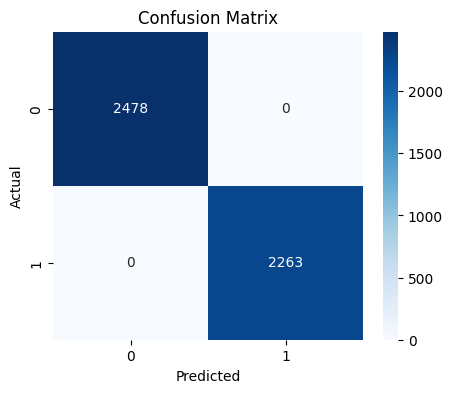

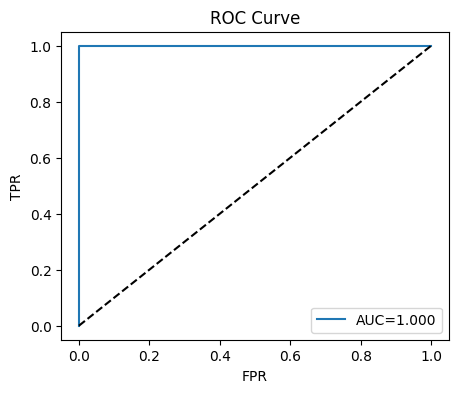

🔧 Best threshold by F1: 0.983

📊 Tuned threshold report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2478
           1     1.0000    1.0000    1.0000      2263

    accuracy                         1.0000      4741
   macro avg     1.0000    1.0000    1.0000      4741
weighted avg     1.0000    1.0000    1.0000      4741

💾 Saved model to: /content/models/ethni_binary_model.pkl
💾 Saved meta to: /content/models/ethni_binary_meta.json

🔎 Example usage:
Example features: {'age': 29.0, 'gender': np.int64(0), 'ethnicity': np.int64(0)}
Prediction: {'prob_1': 0.0, 'label': 0, 'threshold': np.float64(0.9825)}


In [2]:
# =============================================
# PHASE 01 — UPLOAD & EXTRACT
# =============================================
from google.colab import files
import os, zipfile, glob, pandas as pd, numpy as np

print("📤 Please upload your ZIP (e.g., 'ethni.zip') that contains a CSV...")
uploaded = files.upload()  # Choose your ethni.zip

zip_path = list(uploaded.keys())[0]
print(f"✅ Uploaded file: {zip_path}")

EXTRACT_DIR = "/content/ethni_data"
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(EXTRACT_DIR)

print("✅ Extracted to:", EXTRACT_DIR)
!ls -la "$EXTRACT_DIR"

# =============================================
# PHASE 02 — PICK THE RIGHT CSV
#   Prefer largest CSV and avoid dictionary/description files.
# =============================================
import os

all_csvs = glob.glob(os.path.join(EXTRACT_DIR, "**/*.csv"), recursive=True)
if not all_csvs:
    raise FileNotFoundError("No CSV files found inside the ZIP.")

# Sort by size (desc)
all_csvs_sorted = sorted(all_csvs, key=lambda p: os.path.getsize(p), reverse=True)

bad_tokens = {"dictionary", "data_dictionary", "description", "readme", "labels"}
def looks_like_dict(path: str) -> bool:
    name = os.path.basename(path).lower()
    return any(tok in name for tok in bad_tokens)

candidates = [p for p in all_csvs_sorted if not looks_like_dict(p)]
if not candidates:
    candidates = all_csvs_sorted[:]  # fallback

# Try to load the first suitable CSV
encodings_try = [None, "utf-8", "latin-1", "ISO-8859-1"]
df, picked_path, last_err = None, None, None

for p in candidates:
    for enc in encodings_try:
        try:
            tmp = pd.read_csv(p, encoding=enc)
            # Skip tiny 1–3 column helper tables
            if tmp.shape[1] <= 3 and tmp.shape[0] < 50:
                continue
            df = tmp
            picked_path = p
            break
        except Exception as e:
            last_err = e
    if df is not None:
        break

if df is None:
    # final fallback: just load the biggest CSV anyway
    for enc in encodings_try:
        try:
            df = pd.read_csv(all_csvs_sorted[0], encoding=enc)
            picked_path = all_csvs_sorted[0]
            break
        except Exception as e:
            last_err = e
if df is None:
    raise last_err

print("📄 Selected CSV:", picked_path)
print("✅ Loaded CSV:", df.shape)
display(df.head(5))

# =============================================
# PHASE 03 — NORMALIZE & COERCE TYPES
# =============================================
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("🧭 Columns:", df.columns.tolist())

# Drop fully empty columns
df = df.dropna(axis=1, how="all")

# Try coercing common numeric columns
for col in ["age", "height", "width", "x", "y"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# =============================================
# PHASE 04 — CHOOSE / CREATE BINARY TARGET
# Priority:
#   1) gender -> map to {0,1}
#   2) ethnicity/race -> most frequent class vs others
#   3) age -> >=18 vs <18
# =============================================
target_col = None

# 1) gender
for gcol in ["gender", "sex"]:
    if gcol in df.columns:
        # map common forms
        g = df[gcol].astype(str).str.strip().str.lower()
        # Normalize values like 'male','m','1' vs 'female','f','0'
        map_male = {"male","m","man","1","true"}
        map_fem  = {"female","f","woman","0","false"}
        mapped = g.apply(lambda x: 1 if x in map_male else (0 if x in map_fem else np.nan))
        # If many NaNs, try a simple heuristic: contains 'male' → 1, else 0
        if mapped.isna().mean() > 0.5:
            mapped = g.apply(lambda x: 1 if "male" in x else (0 if "female" in x else np.nan))
        if mapped.notna().sum() >= 50 and mapped.nunique() == 2:
            df["binary_target"] = mapped.astype(int)
            target_col = "binary_target"
            chosen_rule = f"{gcol} → male=1, female=0"
            break

# 2) ethnicity / race → top class vs others
if target_col is None:
    for ecol in ["ethnicity","race","ethnic","ethni","race_label","ethnicity_label"]:
        if ecol in df.columns:
            # pick most frequent non-null class as positive (1), others 0
            ser = df[ecol].astype(str).str.strip().str.lower()
            top = ser[ser != ""].value_counts().idx1 if hasattr(ser.value_counts(), "idx1") else ser.value_counts().idxmax()
            df["binary_target"] = (ser == top).astype(int)
            # Ensure we have both classes present
            if df["binary_target"].nunique() == 2 and df["binary_target"].sum() not in (0, len(df)):
                target_col = "binary_target"
                chosen_rule = f"{ecol} → '{top}' vs others (1 vs 0)"
                break
            else:
                df.drop(columns=["binary_target"], errors="ignore", inplace=True)

# 3) age → adult (>=18) vs minor
if target_col is None and "age" in df.columns:
    df["binary_target"] = (pd.to_numeric(df["age"], errors="coerce") >= 18).astype(int)
    if df["binary_target"].nunique() == 2 and df["binary_target"].sum() not in (0, len(df)):
        target_col = "binary_target"
        chosen_rule = "age ≥ 18 → 1 (adult), else 0 (minor)"
    else:
        df.drop(columns=["binary_target"], errors="ignore", inplace=True)

if target_col is None:
    raise ValueError(
        "Could not create a binary target automatically.\n"
        "Expected one of: 'gender'/'sex', 'ethnicity'/'race', or 'age'."
    )

print(f"🎯 Using binary target: {target_col} ({chosen_rule})")
print(df[target_col].value_counts())

# =============================================
# PHASE 05 — FEATURE SELECTION
# Use all columns except target & obvious ID-like fields.
# Numeric: impute median + scale; Categorical: impute mode + one-hot.
# =============================================
drop_cols = {target_col, "id", "image", "img", "path", "file", "filename", "subject", "name"}
X = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()
y = df[target_col].astype(int).copy()

# Identify types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# You can optionally drop ultra-high cardinality categorical columns
# to keep one-hot manageable (e.g., if a column looks like a unique ID).
def too_high_cardinality(s, max_unique=200):
    try:
        return s.nunique(dropna=True) > max_unique
    except Exception:
        return False

cat_cols = [c for c in cat_cols if not too_high_cardinality(X[c])]

print("🔢 Numeric features:", num_cols[:12], "…" if len(num_cols)>12 else "")
print("🔤 Categorical features:", cat_cols[:12], "…" if len(cat_cols)>12 else "")

# =============================================
# PHASE 06 — TRAIN/TEST SPLIT
# =============================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("🧪 Train size:", len(X_train), "| Test size:", len(X_test))

# =============================================
# PHASE 07 — PIPELINE & MODEL (Fixed)
# =============================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", max_categories=50, sparse_output=True)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

model = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

pipe.fit(X_train, y_train)
print("✅ Model trained successfully.")

# =============================================
# PHASE 08 — EVALUATION
# =============================================
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Probabilities if available
if hasattr(pipe.named_steps["model"], "predict_proba"):
    y_prob = pipe.predict_proba(X_test)[:,1]
else:
    y_prob = pipe.decision_function(X_test)

y_pred = (y_prob >= 0.5).astype(int)

print("\n📊 Classification Report:\n", metrics.classification_report(y_test, y_pred, digits=4))
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thr = metrics.roc_curve(y_test, y_prob)
auc = metrics.roc_auc_score(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.show()

# Optional: threshold tuning by F1
prec, rec, thr2 = metrics.precision_recall_curve(y_test, y_prob)
f1 = 2 * (prec*rec) / (prec+rec+1e-9)
best_idx = int(np.nanargmax(f1))
best_thr = thr2[best_idx] if best_idx < len(thr2) else 0.5
print(f"🔧 Best threshold by F1: {best_thr:.3f}")

y_pred_tuned = (y_prob >= best_thr).astype(int)
print("\n📊 Tuned threshold report:\n", metrics.classification_report(y_test, y_pred_tuned, digits=4))

# =============================================
# PHASE 09 — SAVE MODEL & META
# =============================================
import joblib, json
os.makedirs("/content/models", exist_ok=True)
ARTIFACT = "/content/models/ethni_binary_model.pkl"
joblib.dump(pipe, ARTIFACT)
print("💾 Saved model to:", ARTIFACT)

meta = {
    "csv_path": picked_path,
    "target_col": target_col,
    "target_rule": chosen_rule,
    "num_features": num_cols,
    "cat_features": cat_cols,
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
}
with open("/content/models/ethni_binary_meta.json","w") as f:
    json.dump(meta, f, indent=2)
print("💾 Saved meta to: /content/models/ethni_binary_meta.json")

# =============================================
# PHASE 10 — INFERENCE HELPER
# Pass a dict with the same feature names as in X
# =============================================
def predict_one(record: dict, threshold=0.5):
    xx = pd.DataFrame([record])
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        p = float(pipe.predict_proba(xx)[:,1][0])
    else:
        # fallback: decision_function → map via sigmoid-ish scaling not available; use sign
        p = float(pipe.decision_function(xx)[0])
    label = int(p >= threshold)
    return {"prob_1": p, "label": label, "threshold": threshold}

print("\n🔎 Example usage:")
example = {}
for c in ["age"]:
    if c in X_train.columns:
        example[c] = float(np.nanmedian(X_train[c]))
for c in ["gender","ethnicity","race"]:
    if c in X_train.columns:
        example[c] = X_train[c].mode().iloc[0]
print("Example features:", example)
print("Prediction:", predict_one(example, threshold=best_thr))
